In [1]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

In [2]:
def show_img(image):
    plt.figure(figsize=(16,16))
    plt.imshow(image)

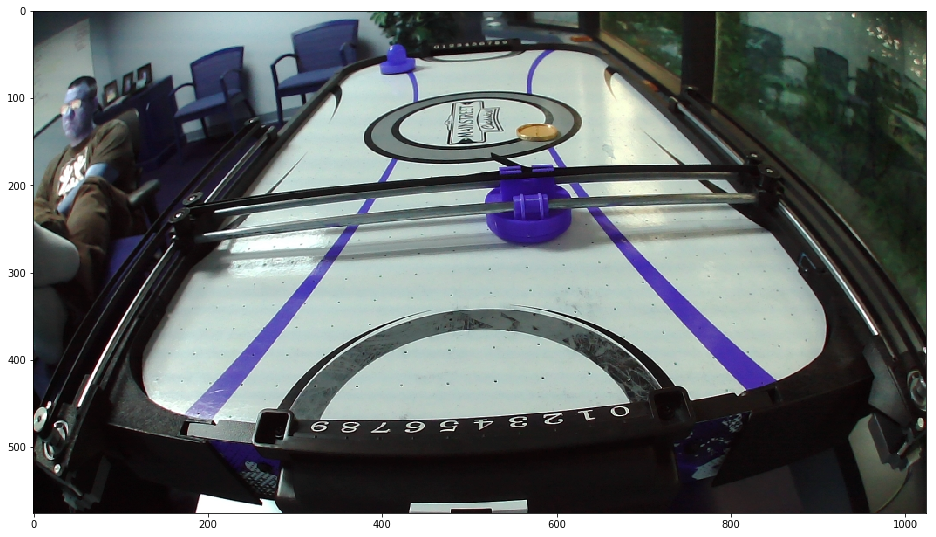

In [17]:
image = cv2.imread("test2.jpg")
show_img(image)

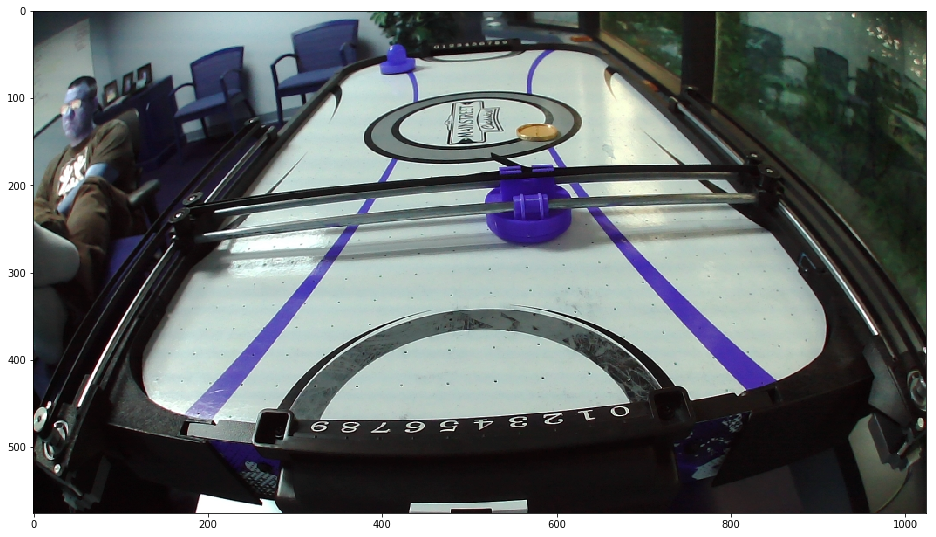

In [18]:
img = imutils.resize(image, width=1024)
show_img(image)

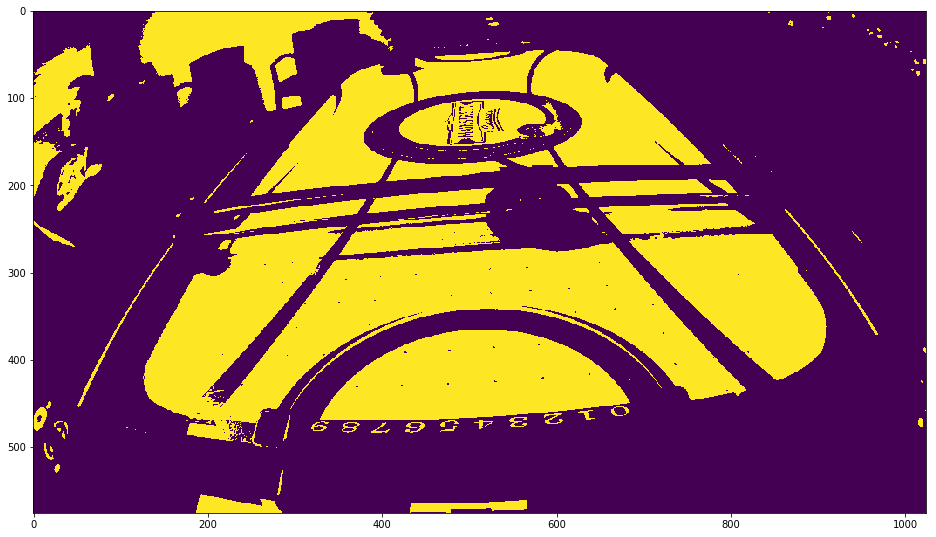

In [21]:
def get_bw_img(image, threshold=150):
    wk_img = image.copy()
    t, bw = cv2.threshold(wk_img, threshold, 255, cv2.THRESH_BINARY)
    return bw.copy()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
bw_img = get_bw_img(image=gray, threshold=140)
show_img(bw_img)

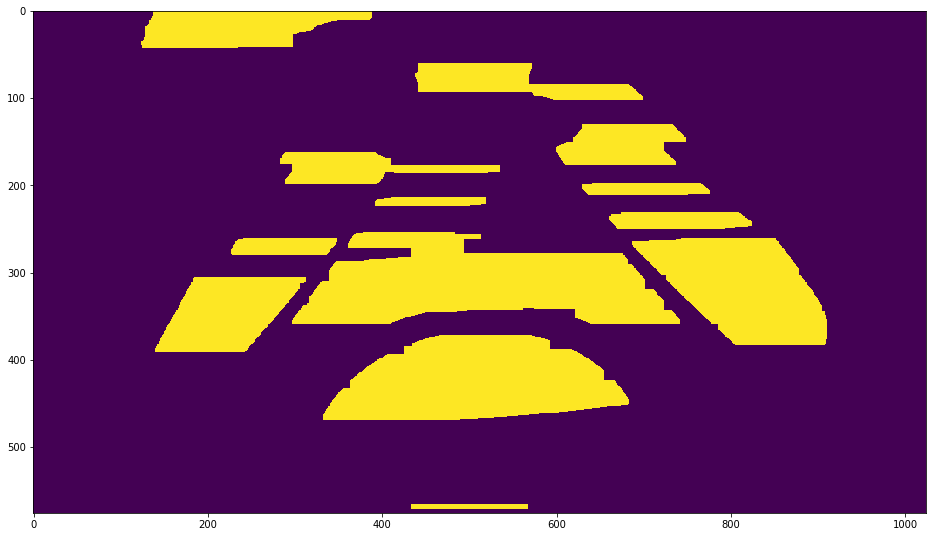

In [22]:
def remove_noise(image):
    wk_img=image.copy()
    
    # Baseline params
    kernel1=5
    kernel2=60
    while True:    
        kernel = np.ones((kernel1,kernel2))
        opened=cv2.morphologyEx(wk_img,cv2.MORPH_OPEN, kernel)    

        zero_count_l=np.count_nonzero(opened[:,:120])
        zero_count_r=np.count_nonzero(opened[:,1780:])
        if zero_count_l > 0 or zero_count_r > 0:
            #kernel1+=1 // maybe? for now let's not.
            kernel2+=1
        else:
            #print "Kernel:",(kernel1,kernel2)
            break

    # this cleans up the noise on the inside and reduces the number of
    # objects/contours.
    closed=cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((10,10)))
    
    return closed.copy()

clean_img = remove_noise(bw_img)
show_img(clean_img)

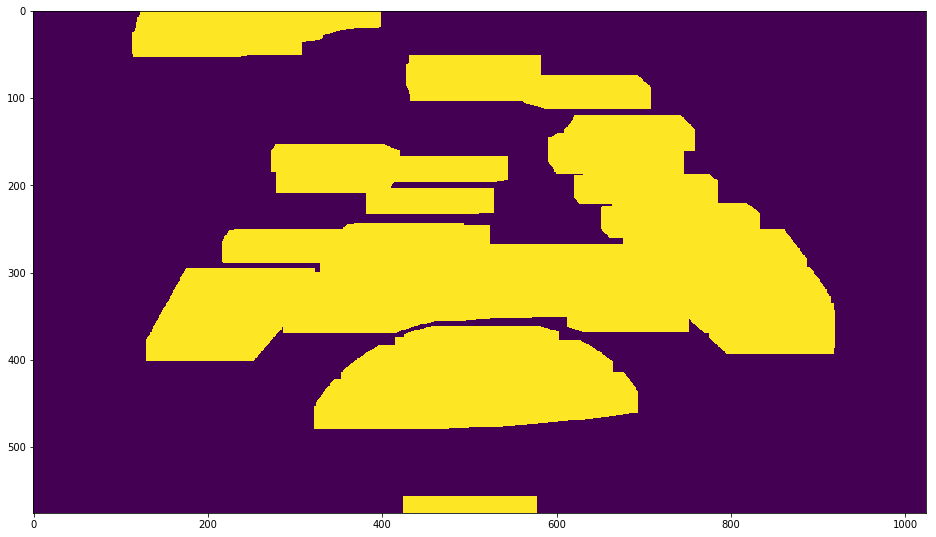

In [135]:
disp = np.zeros_like(clean_img)

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(clean_img, kernel, iterations = 5)
show_img(dilation)

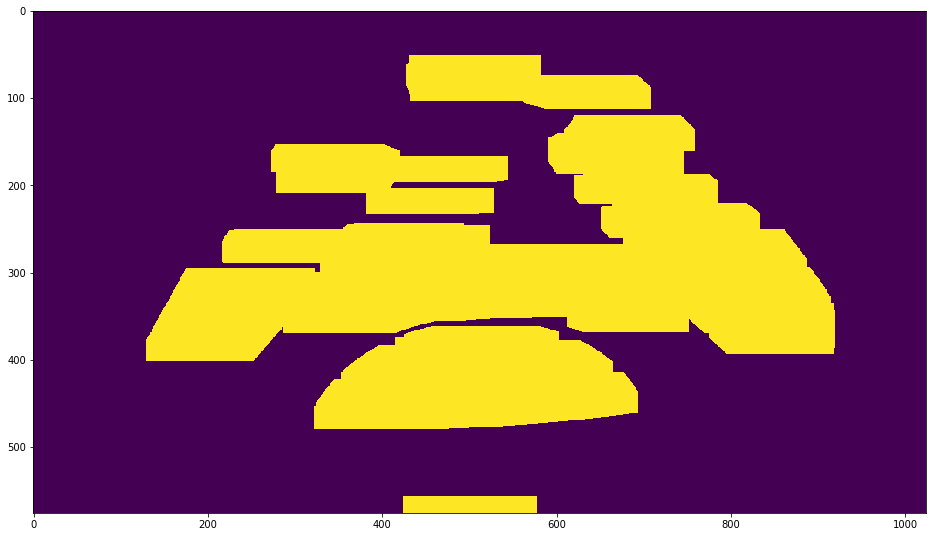

In [136]:
im2, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
off_edge = [contour for contour in contours if np.count_nonzero(contour) == contour.shape[0] * contour.shape[1] * contour.shape[2]]
cv2.drawContours(disp, off_edge, -1, (255,255,255), cv2.FILLED)
show_img(disp)

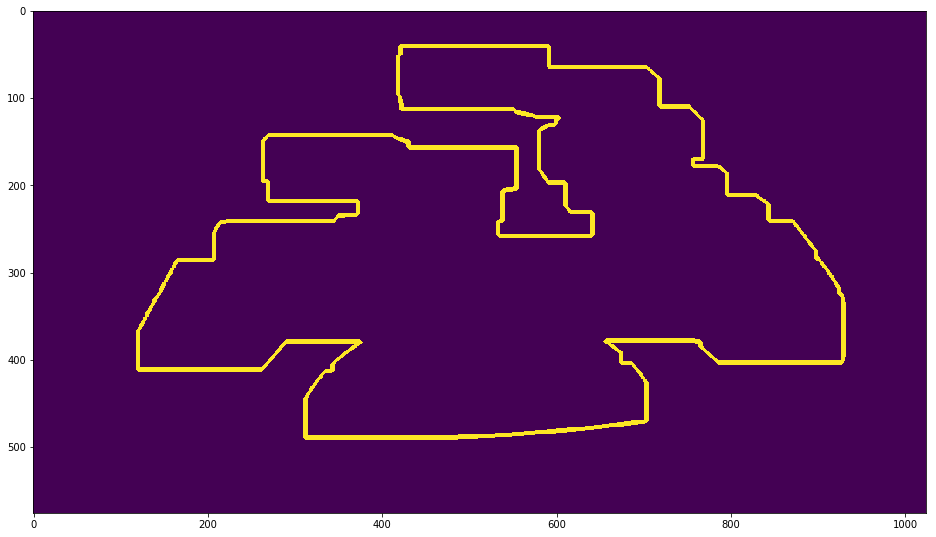

In [140]:
no_lava = np.zeros_like(disp)
flipped = cv2.flip(disp, 0)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(flipped, kernel, iterations = 5)
im2, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
off_edge2 = [contour for contour in contours if np.count_nonzero(contour) == contour.shape[0] * contour.shape[1] * contour.shape[2]]
c = max(contours, key = cv2.contourArea)
cv2.drawContours(no_lava, [c], -1, (255,255,255), 3)
flipped_back = cv2.flip(no_lava, 0)
show_img(flipped_back)

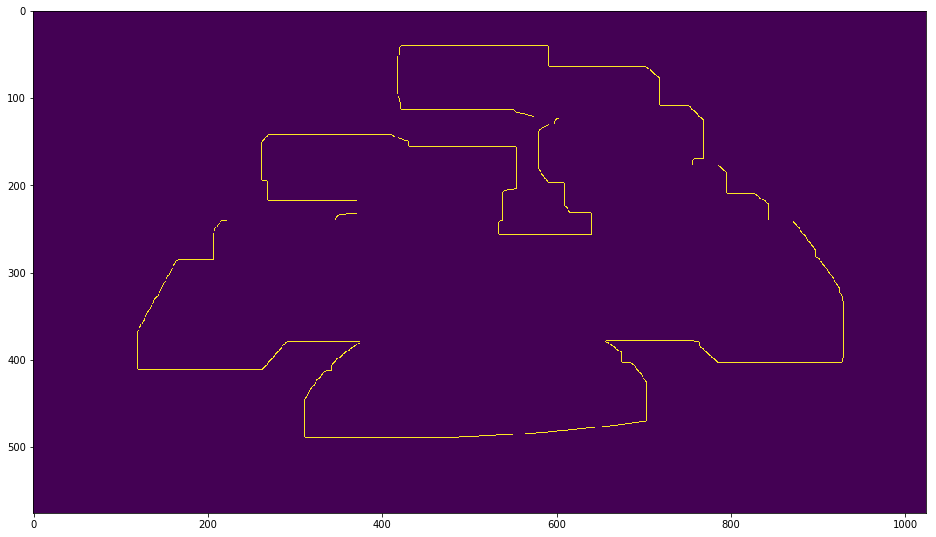

In [138]:
edges = cv2.Canny(flipped_back,1,1)
show_img(edges)

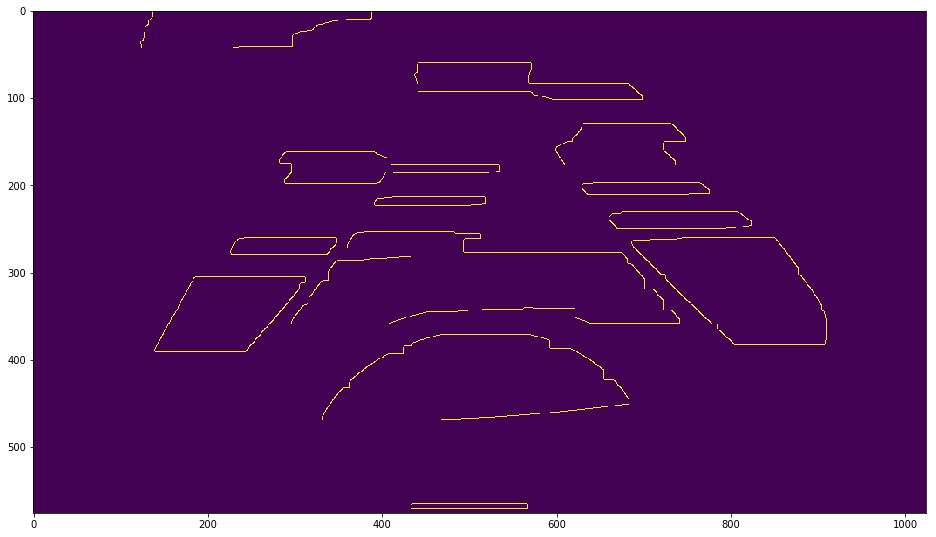

In [88]:
edges = cv2.Canny(clean_img, 1, 1, apertureSize=3)
show_img(edges)

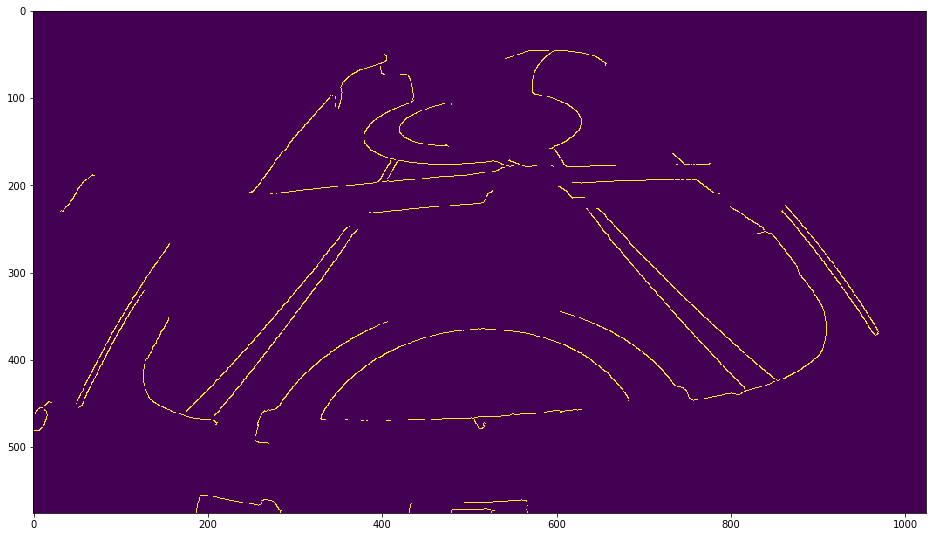

In [67]:
blurred = cv2.GaussianBlur(image, (15, 15), 0)
edges2 = cv2.Canny(blurred,100, 250,apertureSize = 3)
show_img(edges2)

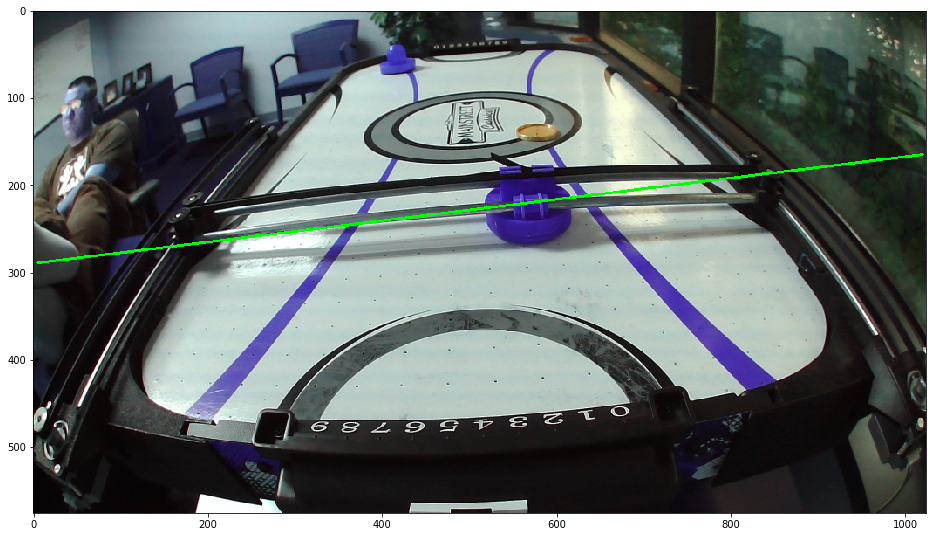

In [61]:
disp = img.copy()
lines = cv2.HoughLinesP(edges2, rho=1, theta=np.pi/180, threshold=25, minLineLength=20, maxLineGap=500)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(disp,(x1,y1),(x2,y2),(0,255,0),2)

show_img(disp)

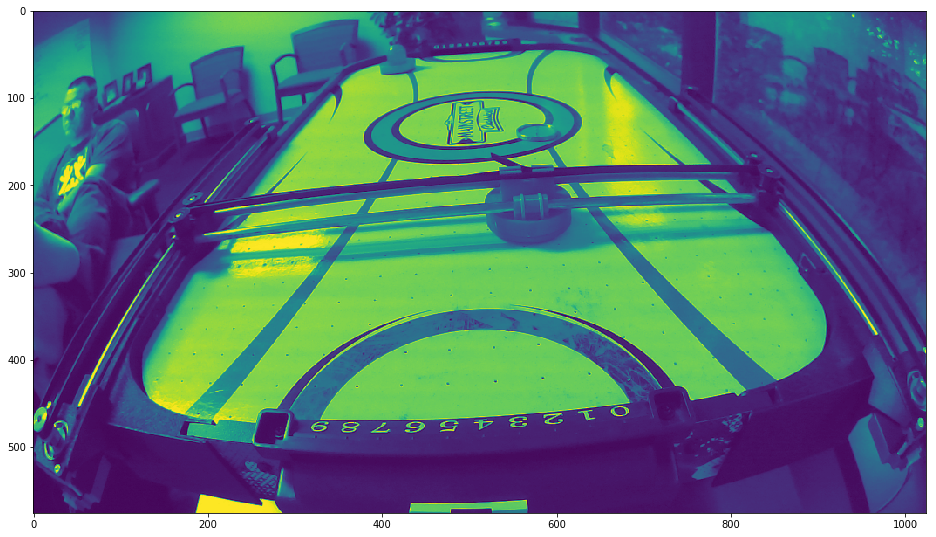

In [7]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_img(gray)

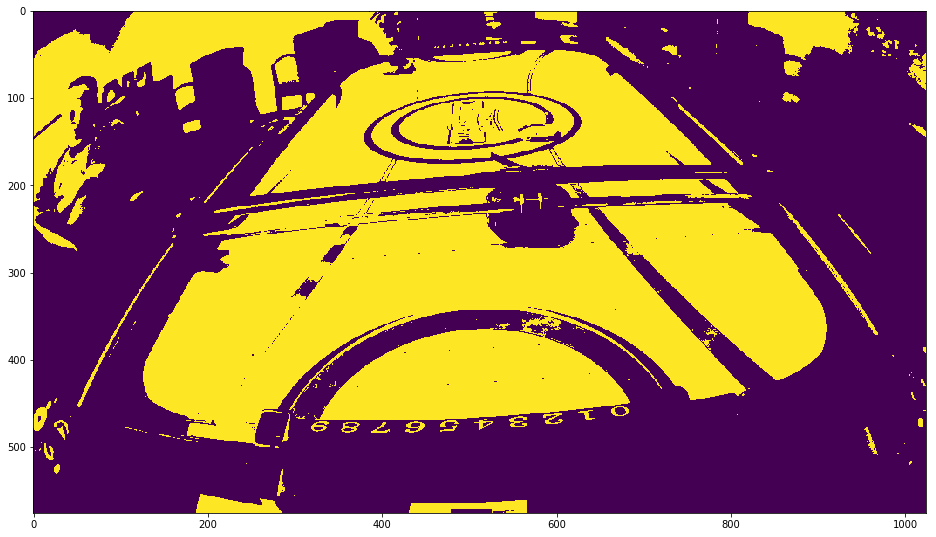

In [8]:
# Apply threshold to grayscale img. (Converts to b&w)
t, bw = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
show_img(bw)

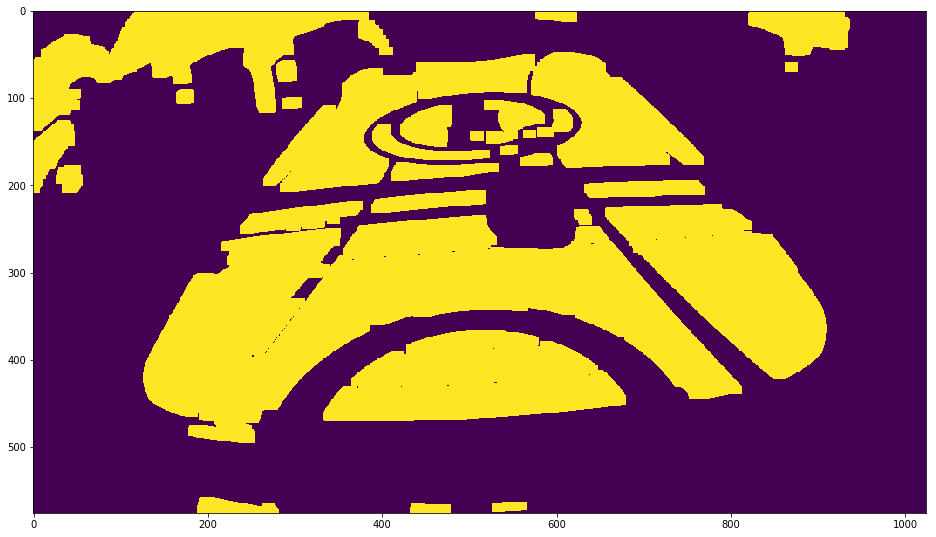

In [15]:
# we only want large objects since we are trying to detect
# the board. 1x60 is a good starting point. Can call again
# with override if the result is not good enough.
# this cleans up the outside noise
opened=cv2.morphologyEx(bw,cv2.MORPH_OPEN, np.ones((10,15)))
show_img(opened)

In [16]:
kernel1=5
kernel2=60
while True:    
    kernel = np.ones((kernel1,kernel2))
    opened=cv2.morphologyEx(opened,cv2.MORPH_OPEN, kernel)    

    zero_count_l=np.count_nonzero(opened[:,:120])
    zero_count_r=np.count_nonzero(opened[:,1780:])
    if zero_count_l > 0 or zero_count_r > 0:
        #kernel1+=1 
        kernel2+=1
    else:
        print("Kernel:",(kernel1,kernel2))
        break

show_img(opened)

KeyboardInterrupt: 

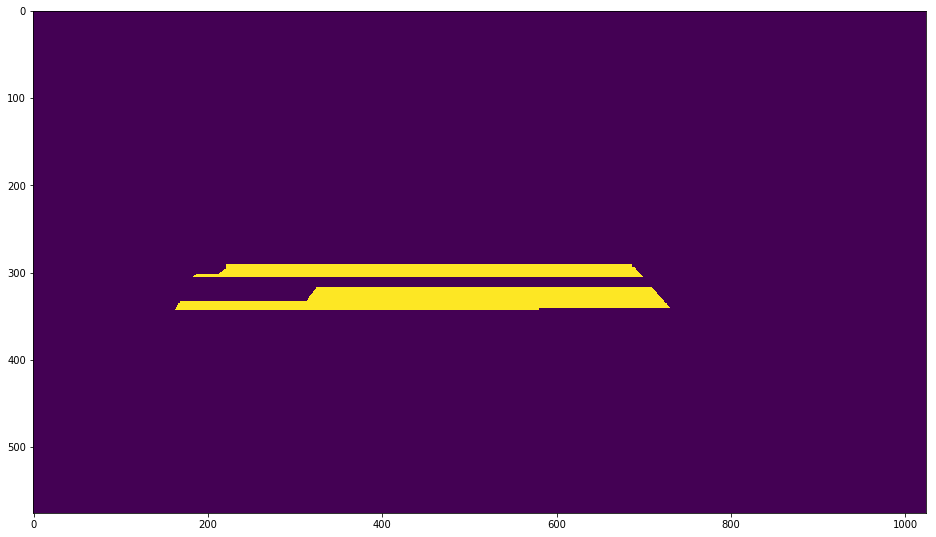

In [11]:
# this cleans up the noise on the inside and reduces the number of
# objects.
closed=cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((10,10)))
show_img(closed)

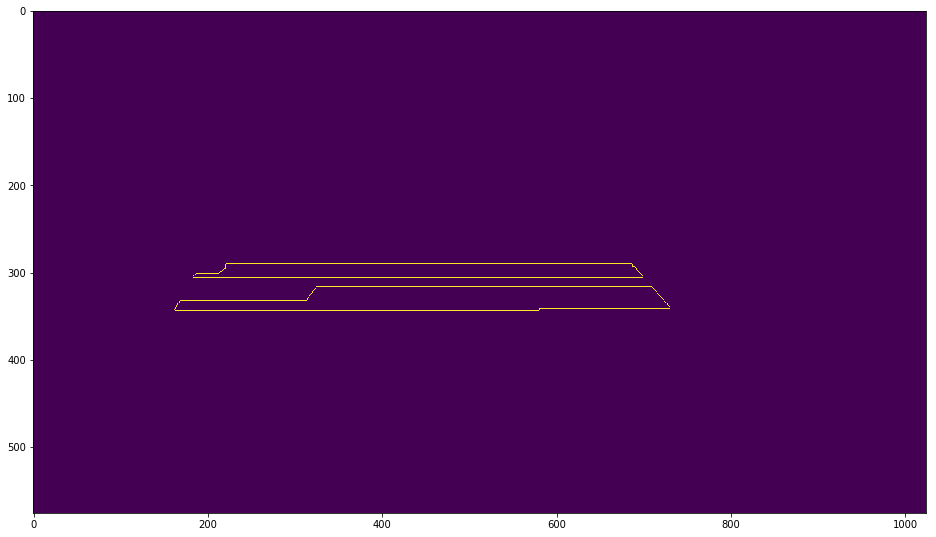

In [12]:
laplacian = cv2.Laplacian(closed,cv2.CV_8UC1)
show_img(laplacian)

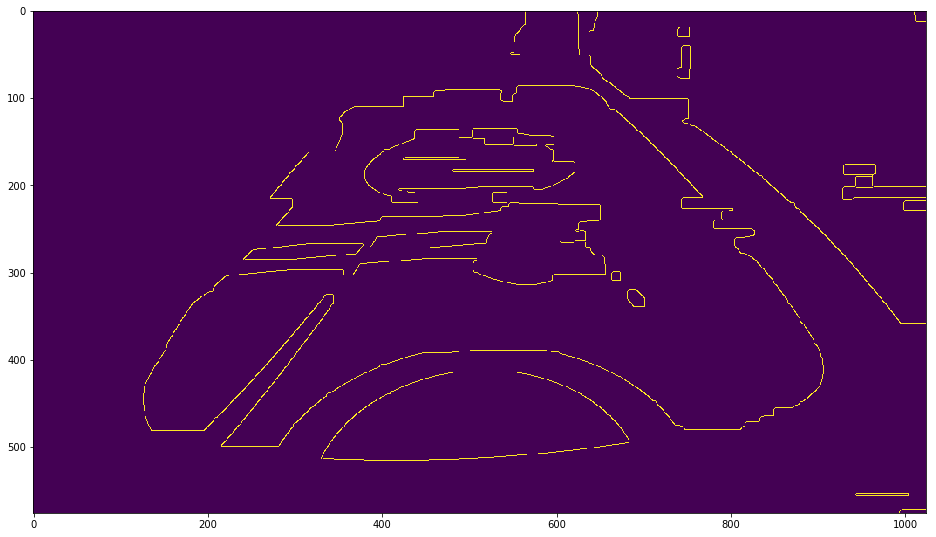

In [33]:
edges = cv2.Canny(closed,1,1)
show_img(edges)

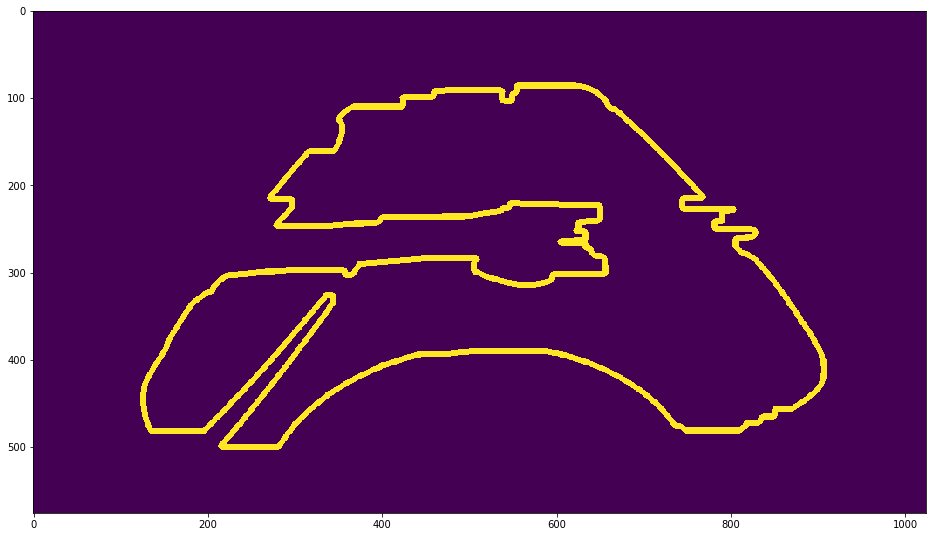

In [34]:
im2, contours, hierarchy = cv2.findContours(laplacian, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

c = max(contours, key = cv2.contourArea)

test = cv2.drawContours(np.zeros_like(laplacian), [c], -1, (255,255,255), 5)

show_img(test)

In [35]:
#(x,y,w,h)=cv2.boundingRect( test ) 
#x,y,w,h
rect = cv2.minAreaRect(c)
box = cv2.boxPoints(rect)
box = np.int0(box)
rect

((511.4588623046875, 289.64324951171875),
 (782.0761108398438, 403.8983459472656),
 -2.0569982528686523)

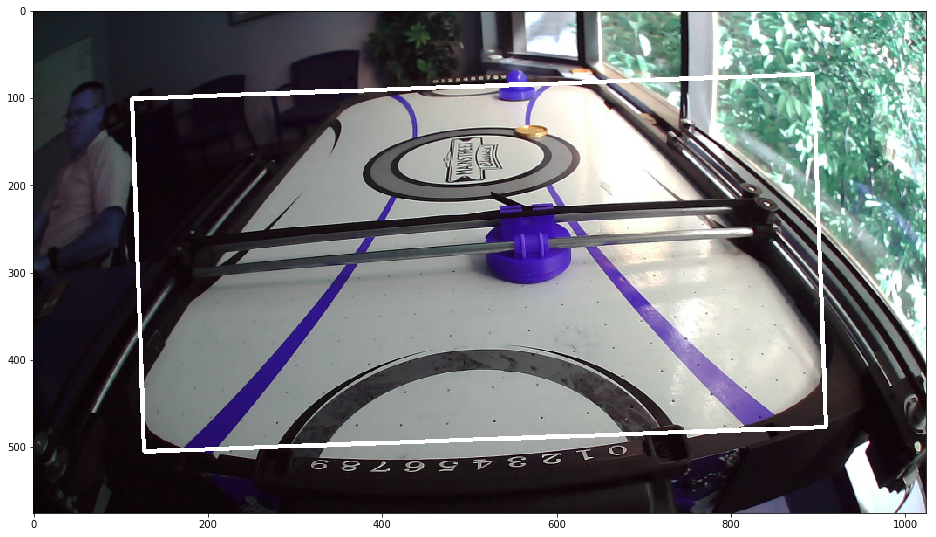

In [43]:
disp=image.copy()
#cv2.rectangle(disp, (x, y), (x+w, y+h), (255, 255, 255), 3);
cv2.drawContours(disp,[box],0,(255,255,255),3)
show_img(disp)

In [38]:
#from scipy.spatial import ConvexHull
#pts = np.array(np.argwhere(test), np.int8)
#pts
a, triangle = cv2.minEnclosingTriangle(c)


In [39]:
print(triangle)


[[[ 469.75836   -56.83557 ]]

 [[  55.160145  508.11145 ]]

 [[1087.645     471.02786 ]]]


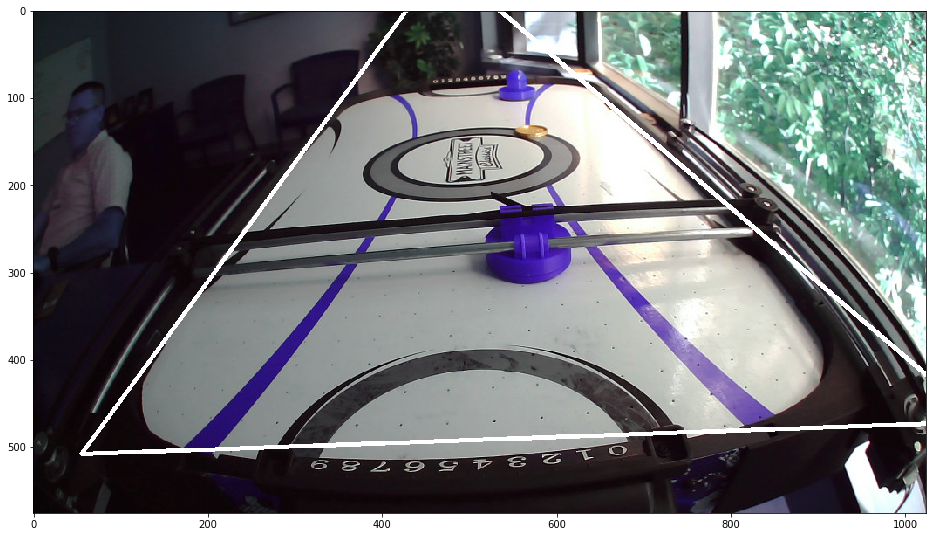

In [42]:
triangle_disp=orig.copy()
img = cv2.line(triangle_disp, (triangle[0][0][0],triangle[0][0][1]), (triangle[1][0][0], triangle[1][0][1]), (255,255,255), 3)
img = cv2.line(triangle_disp, (triangle[1][0][0],triangle[1][0][1]), (triangle[2][0][0], triangle[2][0][1]), (255,255,255), 3)
img = cv2.line(triangle_disp, (triangle[2][0][0],triangle[2][0][1]), (triangle[0][0][0], triangle[0][0][1]), (255,255,255), 3)

show_img(triangle_disp)

In [44]:
from __future__ import division 

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

In [45]:
tri_t=triangle[0]
tri_l=triangle[0]
tri_r=triangle[0]


for i in range(len(triangle)):
    if triangle[i][0][1] < tri_t[0][1]:
        tri_t=triangle[i]
        
    if triangle[i][0][0] < tri_l[0][0]:
        tri_l=triangle[i]
        
    if triangle[i][0][0] > tri_r[0][0]:
        tri_r=triangle[i]


In [81]:
# Convert the points to tuple
tri_bot_right=tuple(tri_r[0])
tri_top=tuple(tri_t[0])
tri_bot_left=tuple(tri_l[0])

rect_top=line(box[2], box[1])
tri_left=line(tri_bot_left, tri_top)
tri_right=line(tri_bot_right, tri_top)

l_intersection=intersection(rect_top, tri_left)
r_intersection=intersection(rect_top, tri_right)

In [82]:
r_intersection

(632.702046056171, 82.36791640259567)

In [83]:
l_intersection

(360.43761126909084, 92.12899729124898)

In [84]:
homography_points = np.array([
    (int(tri_bot_left[0]), int(tri_bot_left[1])),
    (int(tri_bot_right[0]), int(tri_bot_right[1])),
    (int(r_intersection[0]), int(r_intersection[1])),
    (int(l_intersection[0]), int(l_intersection[1]))
])

In [85]:
homography_points

array([[  55,  508],
       [1087,  471],
       [ 632,   82],
       [ 360,   92]])

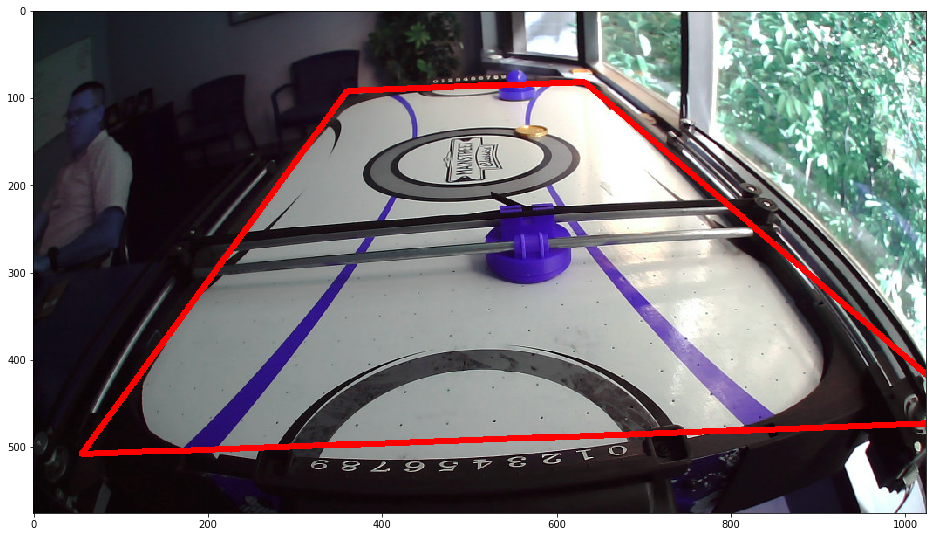

In [86]:
points_img = orig.copy()
img = cv2.polylines(points_img, [homography_points], True, (255, 0, 0), 5)

show_img(points_img)

In [87]:
pts_src = np.array(
    [
        homography_points[0],
        homography_points[1],
        homography_points[2],
        homography_points[3]
    ]
)

pts_dst = np.array(
    [
        [0, 639],
        [479, 639],
        [479, 0],
        [0, 0]        
    ]
)

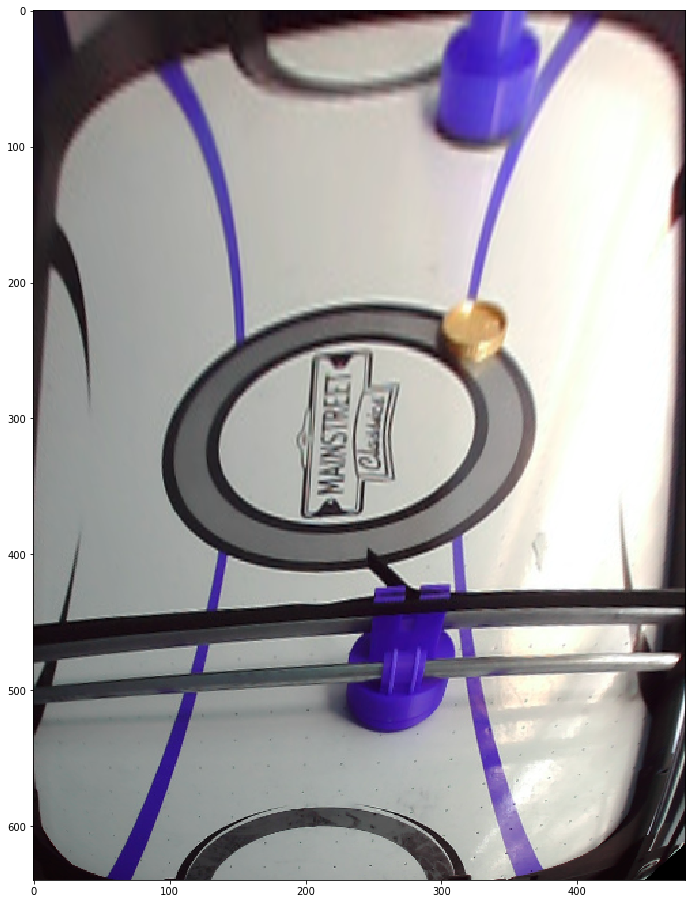

In [88]:
warped_img=orig.copy()
h, status = cv2.findHomography(pts_src, pts_dst)
warped = cv2.warpPerspective(warped_img, h, (480, 640))

show_img(warped)